In [30]:
import gym
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.distributions import Normal, MultivariateNormal



In [58]:
class SAC(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, alpha=1e-3, tau=1e-2, 
                 batch_size=64, pi_lr=1e-3, q_lr=1e-3):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 2 * action_dim), nn.Tanh()).to(self.device)

        self.q1_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1)).to(self.device)

        self.q2_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1)).to(self.device)

        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau
        self.batch_size = batch_size
        self.memory = []

        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), pi_lr)
        self.q1_optimizer = torch.optim.Adam(self.q1_model.parameters(), q_lr)
        self.q2_optimizer = torch.optim.Adam(self.q2_model.parameters(), q_lr)
        self.q1_target_model = deepcopy(self.q1_model)
        self.q2_target_model = deepcopy(self.q2_model)

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action, _ = self.predict_actions(state)
        return action.cpu().squeeze(1).detach().numpy()

    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, done, next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
            states, actions, rewards, dones, next_states = states.to(self.device), actions.to(self.device), rewards.to(self.device), dones.to(self.device), next_states.to(self.device)

            rewards, dones = rewards.unsqueeze(1), dones.unsqueeze(1)

            next_actions, next_log_probs = self.predict_actions(next_states)
            next_states_and_actions = torch.concat((next_states, next_actions), dim=1)
            next_q1_values = self.q1_target_model(next_states_and_actions)
            next_q2_values = self.q2_target_model(next_states_and_actions)
            next_min_q_values = torch.min(next_q1_values, next_q2_values)
            targets = rewards + self.gamma * (1 - dones) * (next_min_q_values - self.alpha * next_log_probs)
            print(rewards.shape,next_min_q_values.shape,dones.shape,next_log_probs.shape)
            states_and_actions = torch.concat((states, actions), dim=1)
            q1_loss = torch.mean((self.q1_model(states_and_actions) - targets.detach()) ** 2)
            q2_loss = torch.mean((self.q2_model(states_and_actions) - targets.detach()) ** 2)
            self.update_model(q1_loss, self.q1_optimizer, self.q1_model, self.q1_target_model)
            self.update_model(q2_loss, self.q2_optimizer, self.q2_model, self.q2_target_model)

            pred_actions, log_probs = self.predict_actions(states)
            states_and_pred_actions = torch.concat((states, pred_actions), dim=1)
            q1_values = self.q1_model(states_and_pred_actions)
            q2_values = self.q2_model(states_and_pred_actions)
            min_q_values = torch.min(q1_values, q2_values)
            pi_loss = - torch.mean(min_q_values - self.alpha * log_probs)
            self.update_model(pi_loss, self.pi_optimizer)
            
    def update_model(self, loss, optimizer, model=None, target_model=None):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if model != None and target_model != None:
            for param, terget_param in zip(model.parameters(), target_model.parameters()):
                new_terget_param = (1 - self.tau) * terget_param + self.tau * param
                terget_param.data.copy_(new_terget_param)

    def predict_actions(self, states):
        means, log_stds = self.pi_model(states).T
        means, log_stds = means.unsqueeze(1), log_stds.unsqueeze(1)
        #print(log_stds.shape)
        dists = Normal(means, torch.exp(log_stds))
        actions = dists.rsample()
        log_probs = dists.log_prob(actions)
        return actions, log_probs

In [73]:
class MeanSTDLinear(nn.Module):
    def __init__(self, input_dim, output_dim, mean_activation = None, std_activation = None):
        super().__init__()
        
        self.mean = nn.Linear(input_dim,output_dim)
        self.std = nn.Linear(input_dim,output_dim)
        self.mean_activation = mean_activation
        self.std_activation = std_activation
        
    def forward(self,x):
        mean = self.mean(x)
        std = self.std(x)
        if self.mean_activation:
            mean = self.mean_activation(mean)
        if self.std_activation:
            std = self.std_activation(std)
            
        return mean,std
    
class Mult(nn.Module):
    def __init__(self, alpha = 1):
        super().__init__()
        self.alpha = alpha
        
    def forward(self,x):
        return torch.mul(x,self.alpha)
        
        
        
class SAC(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, alpha=1e-2, tau=1e-2, 
                 batch_size=64, pi_lr=1e-3, q_lr=1e-3):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 64), nn.ReLU(), 
                                      nn.Linear(64, 64), nn.ReLU(),
                                      MeanSTDLinear(64, action_dim,
                                          nn.Tanh(),
                                          nn.Sequential(nn.Tanh(), Mult(3)))).to(self.device)

        self.q1_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1)).to(self.device)

        self.q2_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1)).to(self.device)

        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau
        self.batch_size = batch_size
        self.memory = []

        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), pi_lr)
        self.q1_optimizer = torch.optim.Adam(self.q1_model.parameters(), q_lr)
        self.q2_optimizer = torch.optim.Adam(self.q2_model.parameters(), q_lr)
        self.q1_target_model = deepcopy(self.q1_model)
        self.q2_target_model = deepcopy(self.q2_model)

    def get_action(self, state):
        state = torch.FloatTensor(state).to(self.device)
        action, _ = self.predict_actions(state)
        return action.cpu().detach().numpy()

    def fit(self, state, action, reward, done, next_state, do_update_pi = True):
        self.memory.append([state, action, reward, done, next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
            states, actions, rewards, dones, next_states = states.to(self.device), actions.to(self.device), rewards.to(self.device), dones.to(self.device), next_states.to(self.device)

            rewards, dones = rewards.unsqueeze(1), dones.unsqueeze(1)
            
            next_actions, next_log_probs = self.predict_actions(next_states)
            next_states_and_actions = torch.concat((next_states, next_actions), dim=1)
            next_q1_values = self.q1_target_model(next_states_and_actions)
            next_q2_values = self.q2_target_model(next_states_and_actions)
            next_min_q_values = torch.min(next_q1_values, next_q2_values)
            targets = rewards + self.gamma * (1 - dones) * (next_min_q_values - self.alpha * next_log_probs)

            states_and_actions = torch.concat((states, actions), dim=1)
            q1_loss = torch.mean((self.q1_model(states_and_actions) - targets.detach()) ** 2)
            q2_loss = torch.mean((self.q2_model(states_and_actions) - targets.detach()) ** 2)
            self.update_model(q1_loss, self.q1_optimizer, self.q1_model, self.q1_target_model)
            self.update_model(q2_loss, self.q2_optimizer, self.q2_model, self.q2_target_model)
            
            if do_update_pi:
                pred_actions, log_probs = self.predict_actions(states)
                states_and_pred_actions = torch.concat((states, pred_actions), dim=1)
                q1_values = self.q1_model(states_and_pred_actions)
                q2_values = self.q2_model(states_and_pred_actions)
                min_q_values = torch.min(q1_values, q2_values)
                pi_loss = - torch.mean(min_q_values - self.alpha * log_probs)
                self.update_model(pi_loss, self.pi_optimizer)
            
    def update_model(self, loss, optimizer, model=None, target_model=None):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if model != None and target_model != None:
            for param, terget_param in zip(model.parameters(), target_model.parameters()):
                new_terget_param = (1 - self.tau) * terget_param + self.tau * param
                terget_param.data.copy_(new_terget_param)

    def predict_actions(self, states):
        means, log_stds = self.pi_model(states)
        dists = MultivariateNormal(means, torch.diag_embed(torch.exp(log_stds)))
        actions = dists.rsample()
        log_probs = dists.log_prob(actions)
        return actions, log_probs

In [74]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = SAC(state_dim, action_dim)

episode_n = 100

total_rewards = []
for episode in range(episode_n):

    total_reward = 0
    state = env.reset()
    
    for t in range(200):
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(2 * action)
    
        agent.fit(state, action, reward, done, next_state)
    
        total_reward += reward
        state = next_state
        if done:
            break

    total_rewards.append(total_reward)
    print(episode,total_reward,end='\r')


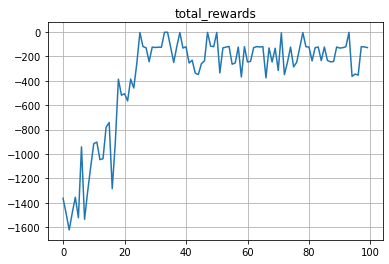

In [76]:

plt.plot(total_rewards)
plt.title('total_rewards')
plt.grid()
plt.show()

In [77]:

total_reward = 0
state = env.reset()

for t in range(200):
    action = agent.get_action(state)
    next_state, reward, done, _ = env.step(2 * action)
    env.render()
    total_reward += reward
    state = next_state